In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
База данных содержит схему `stackoverflow`

In [2]:
db_config = {
    ### private_info
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
# напишите запрос
query = '''
SELECT
    DATE_TRUNC('month', creation_date)::date as month_date,
    SUM(views_count) as total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY 1
ORDER BY 2 DESC;
'''

ex1 = pd.read_sql_query(query, engine)
ex1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


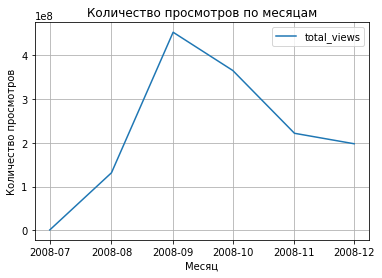

In [7]:
ex1.plot(x='month_date', y='total_views', grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество просмотров');
plt.title('Количество просмотров по месяцам');

**Вывод**:

Количество просмотров постепенно возрастает, начиная с июня, пик приходится на сентябрь, после чего наблюдается спад. 

Пик количества просмотров, вполне вероятно, можно связать с выходом каких-то серьезных обновлений и пользователи стали задавать больше вопросов по новому софту.

В качестве возможной причины можно также предположить, что лето - время отпусков, поэтому просмотров в это время меньше, как следствие, после окончания отпусков, количество просмотров возрастает и потом постепенно выходит на какое-то среднее значение.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [8]:
# напишите запрос
query = '''
SELECT
    us.display_name,
    COUNT(distinct post.user_id)
FROM stackoverflow.posts post
INNER JOIN stackoverflow.post_types ptype
    ON post.post_type_id = ptype.id
    AND ptype.type = 'Answer'
INNER JOIN stackoverflow.users us
    ON post.user_id = us.id
WHERE post.creation_date::date BETWEEN us.creation_date::date AND us.creation_date::date + INTERVAL '1 month'
GROUP BY 1
HAVING COUNT(distinct post.id) > 100
ORDER BY 1 ASC
'''

ex2 = pd.read_sql_query(query, engine)
ex2.head(30)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,15
8,Cade Roux,1
9,CesarB,1


**Вывод**:

Можно предположить, что изменение user_id в рамках одного имени пользователя может быть связано с техническими особенностями Stackoverflow, например при изменении каких-либо данных в профиле, аккаунту назначается новый user_id. Второй вариант, пользовательский профиль однозначно идентифицируется не только по user_id, а, возможно, имеется еще какой-нибудь атрибут. Третий, но маловероятный вариант - отсутствие запрета регистрироваться под уже существующим именем.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [9]:
# напишите запрос
query = '''
WITH t1 AS(
    SELECT
        us.id
    FROM stackoverflow.users us
    INNER JOIN stackoverflow.posts p
        ON us.id = p.user_id
        AND EXTRACT(MONTH FROM p.creation_date) = 12
    WHERE EXTRACT(MONTH FROM us.creation_date) = 9
    GROUP BY 1
)
SELECT
    DATE_TRUNC('month', p.creation_date)::date AS "month",
    COUNT(p.id)
FROM stackoverflow.posts p
INNER JOIN t1
    ON p.user_id = t1.id
GROUP BY 1
ORDER BY 1 DESC
'''

ex3 = pd.read_sql_query(query, engine)
ex3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В итоговый результат не должен был попасть август 2008 года, так как мы заведомо рассматривает пользователей, которые зарегистрированы, начиная с сентября. Проверим, почему так получилось:

In [10]:
query = '''
WITH t1 AS(
    SELECT
        us.id
    FROM stackoverflow.users us
    INNER JOIN stackoverflow.posts p
        ON us.id = p.user_id
        AND EXTRACT(MONTH FROM p.creation_date) = 12
    WHERE EXTRACT(MONTH FROM us.creation_date) = 9
    GROUP BY 1
)
SELECT
    p.*
FROM stackoverflow.posts p
INNER JOIN t1
    ON p.user_id = t1.id
WHERE EXTRACT(MONTH FROM p.creation_date) = 8
'''

ex3_1 = pd.read_sql_query(query, engine)
display(ex3_1.head())

query = '''
SELECT *
FROM stackoverflow.users
WHERE id = 31505
'''
ex3_2 = pd.read_sql_query(query, engine)
display(ex3_2.head())

,id,title,creation_date,favorites_count,last_activity_date,last_edit_date,user_id,parent_id,post_type_id,score,views_count
0,8807,Cannot add WebViewer of ActiveReports to an AS...,2008-08-12 13:15:47,0,2012-08-11 15:32:05.283,2012-08-11 15:32:05,31505,0,1,2,970
1,8876,Evidence Based Scheduling Tool,2008-08-12 14:16:42,8,2013-09-27 20:20:26.243,2013-09-27 20:20:26,31505,0,1,30,2722
2,8899,None,2008-08-12 14:39:20,0,2008-08-12 14:39:20.040,NaT,31505,8807,2,2,0
3,9033,Hidden Features of C#?,2008-08-12 16:32:25,5302,2017-09-25 20:53:48.090,2017-09-25 20:53:48,31505,0,1,1476,618901
4,9049,None,2008-08-12 17:00:35,0,2008-08-12 17:00:35.060,NaT,31505,5916,2,2,0


,id,creation_date,display_name,last_access_date,location,reputation,views
0,31505,2008-09-01,Serhat Ozgel,2018-08-31 14:18:10,"Istanbul, Turkey",13622,2568


**Вывод**:

Действительно, данный user_id соответствует условиям, однако существует какая-то техническая ошибка, которая присвоила данный user_id более ранним постам. Проблему в результате можно решить, добавив дополнительное условие в основной запрос.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [11]:
# напишите запрос
query = '''
SELECT
    user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER 
        (PARTITION BY user_id ORDER BY creation_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_count
FROM stackoverflow.posts
'''

ex4 = pd.read_sql_query(query, engine)
ex4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [12]:
# напишите запрос
query = '''
WITH t1 AS (
    SELECT 
        user_id,
        COUNT(id)
    FROM stackoverflow.posts
    WHERE EXTRACT(MONTH FROM creation_date) = 8
    GROUP BY 1
    HAVING COUNT(id) > 120
),
t2 AS (
    SELECT
        p.user_id,
        DATE_TRUNC('day', p.creation_date)::date AS mday,
        COUNT(p.id) AS count_daily
    FROM stackoverflow.posts p
    INNER JOIN t1
        ON p.user_id = t1.user_id
    WHERE EXTRACT(MONTH FROM p.creation_date) = 8
    GROUP BY 1, 2
    HAVING COUNT(p.id) > 0
)
SELECT 
    user_id,
    AVG(count_daily) AS avg_daily
FROM t2
GROUP BY 1
ORDER BY 2 ASC
'''

ex5 = pd.read_sql_query(query, engine)
ex5.head()

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [13]:
# напишите запрос
query = '''
WITH t1 AS(
    SELECT
        user_id,
        COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date) AS unday
    FROM stackoverflow.posts
    WHERE creation_date BETWEEN '2008-12-01' AND '2008-12-08'
    GROUP BY 1
)
SELECT ROUND(AVG(unday)) AS result FROM t1
'''

ex6 = pd.read_sql_query(query, engine)
ex6

,result
0,2.0


**Вывод**:

В среднем, в период с 1 по 7 декабря 2008 года, пользователи взаимодействовали с платформой два дня. Однако, если исключить уникальные комбинации пользователь - день (т.е. фиксировать не сам факт активности в этот день, а еще количество активности), то в среднем получится 3 дня (надо убрать distinct из подзапроса).

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [14]:
# напишите запрос
query = '''
SELECT
    user_id,
    creation_date,
    TO_CHAR(LAG(DATE_TRUNC('month', creation_date), 2) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month')
FROM stackoverflow.posts
ORDER BY 1,2
'''

ex7 = pd.read_sql_query(query, engine)
ex7.head(10)

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [15]:
# напишите запрос
query = '''
WITH fdt AS(
    SELECT DISTINCT
        user_id,
        MIN(DATE_TRUNC('month', creation_date::date)) OVER (PARTITION BY user_id ORDER BY creation_date::date ASC)::date AS cohort_dt
    FROM stackoverflow.posts
),
profiles AS(
    SELECT
        *,
        COUNT(*) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
    FROM fdt
),
sessions AS(
    SELECT
        user_id,
        DATE_TRUNC('month', creation_date)::date AS session_date
    FROM stackoverflow.posts
    GROUP BY 1, 2
)
SELECT
    p.cohort_dt,
    s.session_date,
    COUNT(p.user_id) AS users_cnt,
    cohort_users_cnt,
    ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profiles p
INNER JOIN sessions s
    ON p.user_id = s.user_id
GROUP BY 1,2,4
'''
ex8 = pd.read_sql_query(query, engine)
ex8.head(10)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


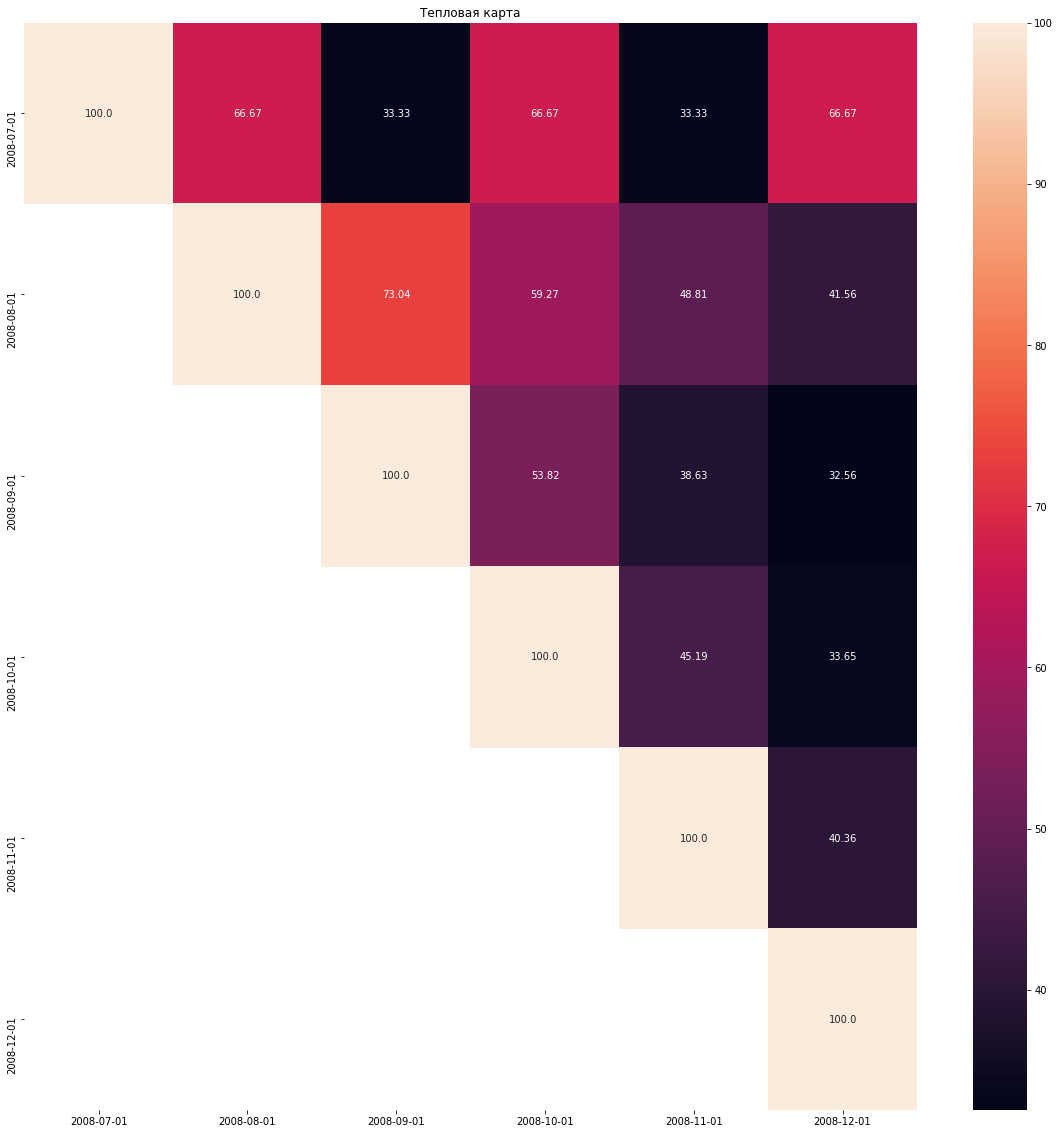

In [16]:
# создаём сводную таблицу с результатами
retention = ex8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:len(str(x))] for x in retention.index]
retention.columns = [str(x)[0:len(str(x))] for x in retention.columns]

plt.figure(figsize=(20, 20))
sns.heatmap(retention,
            annot=True,
            fmt='')
plt.title('Тепловая карта')
plt.show() 

**Вывод**:

Подозрительно выглядит retention rate июльской когорты, так как присутствует очень точная периодичность.

Также очень высокий показатель удержания первого месяца у пользователей августовской когорты.

Дополнительно можно заметить, что наблюдается тенденция по уменьшению процента удержания в целом.

Первый тезис объясняется довольно просто, в когорте всего 3 пользователя, поэтому retention rate данной когорты трудно назвать показательным. Второй тезис можно попытаться связать с повышенным интересом пользователей к какой-то теме, которая имела активное развитие в сентябре. Третий тезис можно связать с увеличением числа пользователей, многие из которых не проявляют активности на сайте, а только лишь заходят, чтобы найти ответ. Соответственно, с течением времени база ответов растёт и необходимость вести активность становится ниже. 

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [17]:
# напишите запрос
query = '''
WITH t1 AS(
    SELECT DISTINCT
        EXTRACT(MONTH FROM creation_date)::integer AS creation_month,
        COUNT(id) OVER (PARTITION BY (EXTRACT(MONTH FROM creation_date))) AS posts_count
    FROM stackoverflow.posts
    WHERE EXTRACT(MONTH FROM creation_date) BETWEEN 9 AND 12
)
SELECT
    *,
    ROUND(((posts_count::numeric / LAG(posts_count::numeric) OVER (ORDER BY creation_month)) - 1) * 100.0, 2) AS percentage
FROM t1
'''

ex9 = pd.read_sql_query(query, engine)
ex9.head(10)

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


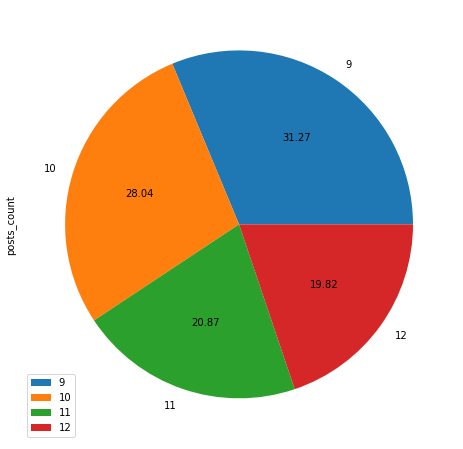

In [18]:
ex9.index = ex9.creation_month
ex9.plot(y = 'posts_count', kind='pie', autopct="%.2f", figsize=(8, 8));

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [19]:
# напишите запрос
query = '''
WITH t1 AS(
    SELECT
        user_id,
        COUNT(id) AS np
    FROM stackoverflow.posts
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 1
)
SELECT DISTINCT
    EXTRACT (WEEK FROM p.creation_date)::integer AS week_creation,
    LAST_VALUE(creation_date) OVER (PARTITION BY EXTRACT (WEEK FROM p.creation_date)::integer ORDER BY creation_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
FROM stackoverflow.posts p
INNER JOIN t1
    ON t1.user_id = p.user_id
WHERE p.creation_date BETWEEN '2008-10-01' AND '2008-11-01'
'''

ex10 = pd.read_sql_query(query, engine)
ex10.head(10)

,week_creation,last_value
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
